# LEARNING THE ART & THE ART OF LEARNING

## Inspiration
Do you imagine how many learning curves have AlphaGo team had to look at, when training their models? This can be fun, but also extremely boring. The idea of this project is to listen the learning progress, and open the doors to create music aided by machine learning.


## What it does
The robot is given a melody, and asked to reproduce it. It's not a very smart robot, and can't do Fourier transforms to guess the notes and the correct ordering. Thus, it needs to do trial and error, pretty much the way we humans do when learning how to play an instrument from scratch. We believe our approach opens the door to explore live-coding in a semi-automatic fashion, where an ensemble of robots is asked to "copy" the melody that its partner has played before: the randomness introduced from the learning curve, aided with hyperparameter tuning done by the live-coder-human musician, can potentially give rise to very funny musical pieces!

## How we built it
We use an algorithm inspired in how pets are trained (see for example, Pavlov's dog story); a reward is given to the robot if the right note is played, an a penalty is given otherwise. Specifically we use Q-learning, which is a reinforcement learning algorithm inspired in the concept of a 'fixed point' of a mathematical map. As the robot explores the space of possible melodies, it learns which was the right note to play at each time, and thanks to SuperCollider we are able to reproduce the melody played by the robot at each trial.

## Challenges we ran into
Live coding was entirely new to the three of use, and we had no skills regarding software manipulation in this area (such as OSC, or SuperCollider). It was pretty challenging to incorporate all the ideas we had, but thanks to the expertise from the mentors, we managed to come up with a proof of concept.

## Accomplishments that we're proud of
We're pretty proud of being able to wake up a Sunday morning! Also, it is quite amazing to have a proof of concept of something we had no idea it even exists a day ago. All in all, it's been a great experience.

## What we learned
We learned the basics of live-coding, and take out home a lot (really, a lot) of resources, ideas, and fiends!

## What's next for Learning the art & The art of learning
We'd like to explore the interaction between agents that are a priori independent, but asked to copy the melodies the remaining ones have learned; the latter combined with hyperparameter tuning - we believe - can potentially give rise to an interesting symbiosis between humans and AI-machines in the context of live-coding.

# SOME CODE:

In the following we include a self-contained code, in order to reproduce the learning of melody playing. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
        
    def give_transition_matrix(self,melody):
        lookup = np.empty((5))
        lookup[[0,1,2,3,4]] = np.arange(5)
        counts = np.zeros((5,5))
        np.add.at(counts, (melody[:-1], melody[1:]),1 )
        probs = counts/counts.sum(axis=0, keepdims=True)
        self.transitions.append(probs)
        return probs
    

class Evaluator():
    def __init__(self):
        self.reward_history = []
        self.trajectories = []
        self.trajectories_eval = []
    def give_reward(self, guess, label):
        if guess == label:
            return 1
        else:
            return 0
        
class Agent():
    def __init__(self, notes_to_choose, gamma=0., ep=0.01):
        self.n_actions = notes_to_choose
        self.states = notes_to_choose
        self.q = np.zeros((notes_to_choose, notes_to_choose))
        self.n = np.zeros((notes_to_choose, notes_to_choose))
        
        self.epsilon = ep
        self.gamma = gamma
        
    def give_action(self, state, greedy=False):
        if np.random.random()<self.epsilon and (greedy == False):
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[state,:]
            qs = np.where( qs == np.max(qs) )[0]
            return np.random.choice(qs, 1)[0]
            

    def q_learn(self, ts):
        ### q-learn
        for interaction in ts:
            s, a, r, ns = interaction
            if ns != -1:
                self.n[s,a]+=1
                self.q[s,a] += (r+ self.gamma*np.max(self.q[ns,:]) - self.q[s,a])/self.n[s,a]
            else:
                self.n[s,a]+=1
                self.q[s,a] += (r- self.q[s,a])/self.n[s,a]
                
    def decrease_ep(self,ind):
        self.epsilon = max(self.epsilon*np.exp(-(ind+1)/100), 0.01)
        return
    
    def give_melody(self, melody):
        note_player=[]
        for ind,note in enumerate(melody):
            note_player.append(self.give_action(note, greedy=True))
        return note_player

# Let's run the code!

100%|██████████| 31/31 [00:00<00:00, 3107.63it/s]


Text(0.5, 1.0, 'Learning curve')

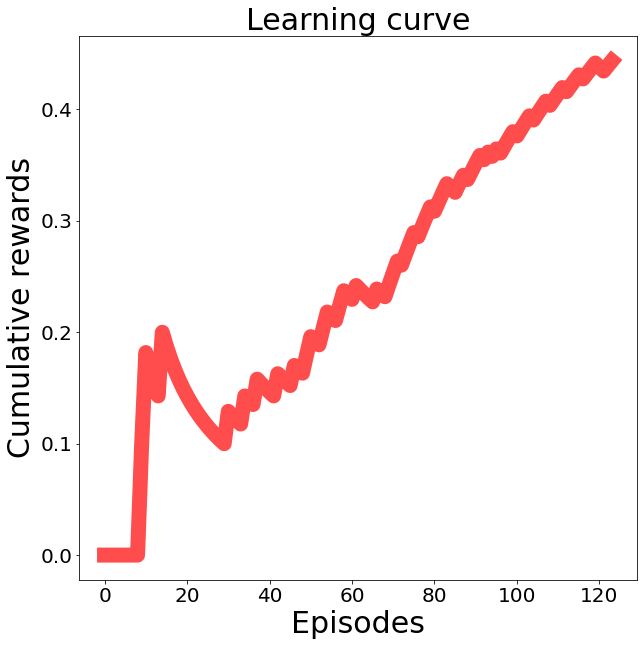

In [8]:
evaluator = Evaluator()
agent = Agent(12, gamma=0., ep=1)
episode_evaluate = [0,1,2,3,10,20,30] #[int(k) for k in np.logspace(0,4,10)]#np.logspace(0,4,10)#[0,1,3,5,10,50]#100,500]#list(range(10))#[0, 10, 50,100]

melody = [0,1,2,3] 

for episode in tqdm(range(31)):
    ts=[]
    actions=[]
    for ind,note in enumerate(melody):
        action = agent.give_action(note)
        actions.append(action)
        reward = evaluator.give_reward(action,note)
        evaluator.reward_history.append(reward)
        if ind!=len(melody)-1:
            next_state = action
        else:
            next_state = -1
        ts.append([note, action, reward, next_state])
        
        
    agent.q_learn(ts)
    agent.decrease_ep(episode)
    #evaluator.trajectories.append(actions)
    
    if episode in episode_evaluate:
        evaluator.trajectories_eval.append(agent.give_melody(melody))
        evaluator.trajectories.append(actions)

        
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(evaluator.reward_history)/np.arange(1,len(evaluator.reward_history)+1), linewidth=15, alpha=0.7,color="red")
plt.xlabel("Episodes",size=30)
plt.ylabel("Cumulative rewards", size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Learning curve", size=30)

# CHECK OUT LEARNING CURVE WITH LONGER TRAINING!

100%|██████████| 1000/1000 [00:00<00:00, 4732.41it/s]


Text(0.5, 1.0, 'Learning curve')

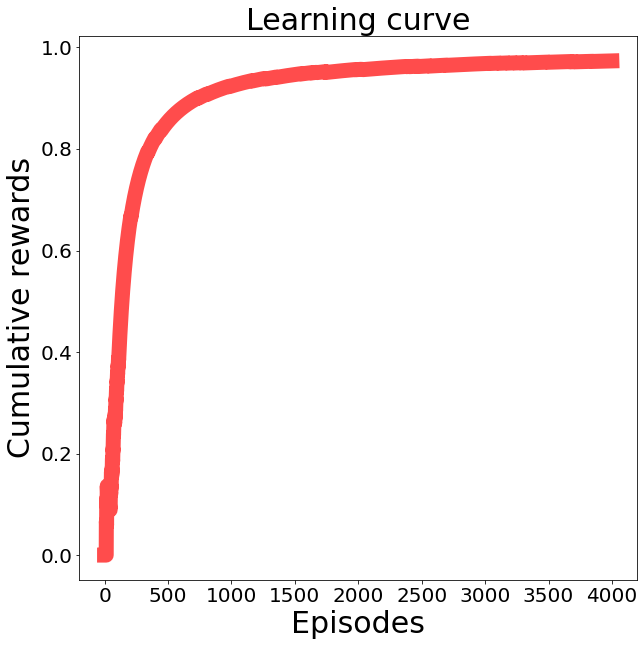

In [4]:


evaluator = Evaluator()
agent = Agent(12, gamma=0., ep=1)
episode_evaluate = [0,1,2,3,10,20,30] #[int(k) for k in np.logspace(0,4,10)]#np.logspace(0,4,10)#[0,1,3,5,10,50]#100,500]#list(range(10))#[0, 10, 50,100]

melody = [0,1,2,3] 

for episode in tqdm(range(10**3)):
    ts=[]
    actions=[]
    for ind,note in enumerate(melody):
        action = agent.give_action(note)
        actions.append(action)
        reward = evaluator.give_reward(action,note)
        evaluator.reward_history.append(reward)
        if ind!=len(melody)-1:
            next_state = action
        else:
            next_state = -1
        ts.append([note, action, reward, next_state])
        
        
    agent.q_learn(ts)
    agent.decrease_ep(episode)
    #evaluator.trajectories.append(actions)
    
    if episode in episode_evaluate:
        evaluator.trajectories_eval.append(agent.give_melody(melody))
        evaluator.trajectories.append(actions)

        
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(evaluator.reward_history)/np.arange(1,len(evaluator.reward_history)+1), linewidth=15, alpha=0.7,color="red")
plt.xlabel("Episodes",size=30)
plt.ylabel("Cumulative rewards", size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Learning curve", size=30)

# SAVE MELODIES!

In [ ]:
os.makedirs("rl_trajs_more", exist_ok=True)
os.system("rm -r rl_trajs_more/*")

for ind,p in enumerate(evaluator.trajectories):
    dictionary={"notas1":[66,64,60,70,62], "weight":p}
    dd = pd.DataFrame.from_dict(dictionary, orient="index")
    dd.to_csv("rl_trajs"+"/episode_{}".format(ind), header=False)

## Some pictorical GIF... (too fast though)

![SegmentLocal](figures/melody.gif "segment")